# Assignment 2 Answers
## Part A:

In [96]:
!pip install ucamcl --upgrade
import ucamcl
GRADER = ucamcl.autograder('https://markmy.solutions', course='scicomp', section='assignment2b')

Waiting for you to log in ....... done.


In [7]:
# Import modules, and give them short aliases so we can write e.g. np.foo rather than numpy.foo
import math, random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import pandas
# The next line is a piece of magic, to let plots appear in our Jupyter notebooks
%matplotlib inline  

### Question 1.

In [1]:
def pairs(N):
    popvect = np.random.permutation(np.arange(N))
    m1 = popvect[:math.ceil(N/2)] # in the event of an odd population, the additional individual is assigned to the m1 vector
    m2 = popvect[-(N//2):]
    return (m1,m2)

### Question 2.

In [106]:
def kinetic_exchange(v,w):
    R = np.random.random(v.size)
    onevec = np.ones(v.size)
    vnew = R*(v+w)
    wnew = (onevec-R)*(v+w)
    return(vnew,wnew)

### Question 3.

In [3]:
def gini(w):
    w = np.sort(w)
    popsize = w.size
    i = np.arange(1,popsize+1)
    numer = sum(i*w)
    denom = w.size*sum(w)
    G = 2*(numer/denom) - (1+(1/popsize))
    return G

### Question 4.

In [104]:
def sim(N,T):
    #initialisation
    wealthLog = np.full(shape=(T,N), fill_value = 1.0)
    '''creates a vector that stores the wealth of an individual
    with distinguishment between persons provided by
    vector index position, each wealth value is associated 
    with the iteration of kinetic exchange that produced it
    again by index of the subvector'''
    ginis = np.zeros(T)
    for i in range(1,T):
        (m1,m2) = pairs(N)
        vin = wealthLog[i-1,m1]
        win = wealthLog[i-1,m2]
        #what were the previous wealth values?
        (vnew,wnew) = kinetic_exchange(vin,win)
        #conduct an exchange
        wealthLog[i,m1] = vnew
        wealthLog[i,m2] = wnew
        #set this generation's wealth values to the resultant
        ginis[i] = gini(wealthLog[i])
        #calculate the associated gini value of this generation
    return(wealthLog[T-1],ginis)
#returns the final iteration of wealth values along with a gini vector

### Question 5.

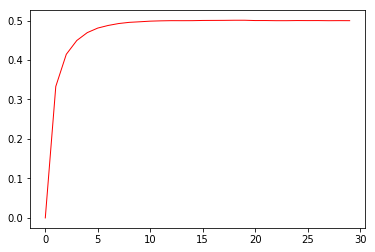

0.499637262004744
0.4997427084165733


In [389]:
(w,gs) = sim(500000,30)
#simulating the desired example
plt.plot( np.arange(30) ,gs, linestyle='-', linewidth=1, color='red')
#plotting a graph with x-axis corresponding to each timestep and y-axis
#to the range of gini values
plt.show()
#demonstrate the plot
print(gs[29])
print(gs[28])

## Part B:

### Question 6:

In a perfectly mobile economy, the fraction of people expected to move more than one quintile is 0.48. This value was acquired through a computational approach in which the below function was developed in order to ascertain the quantity of indivduals that move more than one quintile from an intial time condition to that incremented by a time step. Through substition of a sufficiently large population and timestep, the limiting case of movement fraction was determined.

In [148]:
'''Another simulation function required definitoin that could take input
of a wealth vector and proceed with simulation from there or additoinal timesteps.'''
def successivesim(ws,gs,dT):
    wealthLog = np.full(shape=(dT,ws.size), fill_value = 1.0)
    #create a new wealth array with dimesions corresponding to number of timesteps against that of the population
    wealthLog[0]=ws
    #set the first wealth vector in the array to be that of the inital input
    ginis = np.append(gs,np.zeros(dT))
    #extend the ginis array to account for the additional timesteps
    #repeat the simulation process as before:
    for i in range(1,dT):
        (m1,m2) = pairs(ws.size)
        vin = wealthLog[i-1,m1]
        win = wealthLog[i-1,m2]
        (vnew,wnew) = kinetic_exchange(vin,win)
        wealthLog[i,m1] = vnew
        wealthLog[i,m2] = wnew
        ginis[i+gs.size] = gini(wealthLog[i])
    return(wealthLog[dT-1],ginis)

In [29]:
'''As described above.'''
def question6econmobility(N,T,deltaT):
    def quintiles(vec):
        qs = np.percentile(vec,np.linspace(20,100,5))
        return np.digitize(vec,qs)
    (ws,gs) = sim(N,T)
    quinAttr = quintiles(ws).astype(np.int)
    (newws,gs) = successivesim(ws,gs,deltaT)
    newquinAttr = quintiles(newws).astype(np.int)
    def movemorethan1(before,after):
        change = np.vectorize(abs)(np.subtract(before,after))
        morethan1 = np.where(change>1)[0]
        return morethan1.size
    return (movemorethan1(quinAttr,newquinAttr)/N)*100
    
question6econmobility(100,2,6)

43.0

### Question 7:

In [108]:
def mobility(v,w):
    '''define a function that takes in a vector and
    returns a vector with a value between 1 to 5 that
    indicates the quintile that the original value in that
    index corresponds to'''
    def quintiles(vec):
        qs = np.percentile(vec,np.linspace(20,100,5))
        #identifies what the quintiles are
        return np.digitize(vec,qs)
        '''creates a new vector placing each value into a bin
        depending on the comparison between the value at that
        index and the quintiles'''
    qv = quintiles(v).astype(np.float)
    #find the quintile bins vector for v
    qw = quintiles(w).astype(np.float)
    #find the quintile bins vector for w
    '''define a function that determines whether the same
    index position and hence indivdual has moved by 
    more than one quintile bin'''
    def movemorethan1(before,after):
        change = np.vectorize(abs)(np.subtract(before,after))
        morethan1 = np.where(change>1)[0]
        return morethan1.size
    return (movemorethan1(qv,qw)/v.size)
    #return the proportion

### Question 8:

In [11]:
'''The stability of the kinetic exchange model was determined
through running the simulation with an incrementation in total
duration and determining the time value for which the last
4 consecutive gini values were sufficiently close 
(to within 0.005 of each other). Gini value convergence or 
minimal fluctuation is an indication of exchange model
stabilisation.'''
def wealthstabilisation():
    i=6 #know from above graph that less than 6 timesteps
        #definitely does not lead to a limiting gini value
    (ws,gs) = sim(500,i)
    def convergence(gs):
        elastgs = np.array([gs[-2],gs[-4]])
        olastgs = np.array([gs[-1],gs[-3]])
        if np.allclose(olastgs,elastgs,atol=0.005):
            return True
        else:
            return False
    gss=gs
    while(not convergence(gss)):
        (ws,gss) = successivesim(ws,gss,i)
    return i

'''By virtue of the inherent instability of the exchange model
and the gini calculation, the termination value was found on
mulitple occasions and a mean calculated. A sampe of 200
T values was used for an average.'''
def termvalaverage():
    x=np.array([])
    for i in range(0,200):
        x=np.append(x,wealthstabilisation())
    return np.mean(x)


aT = termvalaverage() #assigning the variable T to the value of time for kinetic exchange stabilisation

### Question 9:

In [162]:
'''Forming a vector of mobility values across incrementations in timestep from that of stabilisation of the kinetic exchange model.'''
def wealthafterstability():
    T = math.floor(aT)
    (wT,gT) = sim(500000,T)
    #the vector containing the proportion that move by more than 1 qunitle value
    quintilefraction = np.ones(20)
    #20 timesteps were applied to the stabilisation value
    for i in range(1,21):
        (wTt,gTt) = successivesim(wT,gT,i)
        quintilefraction[i-1] = mobility(wT,wTt)
    return quintilefraction

ys = wealthafterstability()
print(ys)

[0.       0.29122  0.401476 0.443374 0.462234 0.471904 0.475628 0.477848
 0.478482 0.478548 0.478972 0.48041  0.480558 0.47902  0.479366 0.480466
 0.479512 0.48075  0.47971  0.480368]


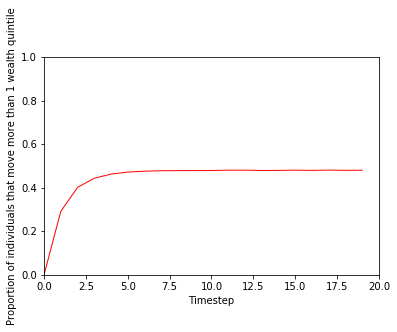

In [165]:
#corresponding graphical plot
plt.plot(np.arange(0,20), ys, linestyle="-",linewidth=1,color='red')
plt.ylabel("Proportion of individuals that move more than 1 wealth quintile")
plt.xlabel("Timestep")
plt.axis([0,20,0,1])
plt.show()